## RandomForest Classifier with bubble related features

### Features
1. Percentage of image covered by bubbles ('area_coverage')
2. Average bubble area ('avg_area')
3. Average bubble circularity ('avg_circularity')
4. Number of bubbles ('num_bubbles')
5. Standard deviation of bubbles areas ('std_area')
6. Average bubble perimeter ('avg_perimeter')


In [13]:
from pprint import pprint
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [14]:
FEATURES_TO_USE_FOR_TRAINING  = [
    'area_coverage', 
    'avg_area', 
    'avg_circularity', 
    'num_bubbles', 
    'std_area', 
    'avg_perimeter'
]

## Bubble Detection Feature Extraction Steps

---
### Step 1: Convert Image to Grayscale
```python
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
```
**Purpose:**
- Simplifies processing by removing color information
- Reduces computational complexity
- Makes bubble boundaries more visible

**Output:**
- Grayscale image (single channel, 0-255 intensity values)
---

### Step 2: Contrast Limited Adaptive Histogram Equalization (CLAHE)
```python
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced = clahe.apply(gray)
```
**Purpose:**
- Mitigates low-contrast problem in images, makes bubble edges more distinguishable from the background
- Adaptive approach prevents over-enhancement in bright areas

**What it does:**
- Divides image into 8×8 pixel tiles
- Enhances local contrast in each tile independently

**Output:**
- Enhanced grayscale image with improved local contrast

**Parameters:**
- `clipLimit=3.0`: Limits contrast amplification to prevent noise
- `tileGridSize=(8,8)`: Size of local regions for adaptive enhancement
---

### Step 3: Non-Local Means Denoising
```python
denoised = cv2.fastNlMeansDenoising(enhanced, h=10)
```

**Purpose:**
- Reduce noise from the image
- Minimise false bubble detection from noise
- Maximise the preservation bubble edges

**What it does:**
- Smooths the image while preserving edges

**Output:**
- Denoised image with reduced grain/noise

**Parameters:**
- `h=10`: Filter strength (higher = more denoising, but may blur edges)
---

### Step 4: Adaptive Thresholding
```python
thresh = cv2.adaptiveThreshold(
    denoised,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    101,  # Block size
    3     # C value
)
```

**Purpose:**
- Separates bubbles from background
- Adaptive approach handles varying lighting across the image
- Creates clear boundaries for contour detection

**What it does:**
- Converts grayscale to binary (black/white) image
- Uses local neighborhood (block size in pixels × block size in pixels) to determine threshold
- Inverts result so bubbles are white, background is black

**Output:**
- Binary image where bubbles = white (255), background = black (0)


**Parameters:**
- `blockSize=101`: Size of local neighborhood (must be odd)
- `C=3`: Constant subtracted from weighted mean
- `THRESH_BINARY_INV`: Inverts output (bubbles become white)
---

### Step 5: Morphological Cleaning
```python
kernel = np.ones((3,3), np.uint8)
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel, iterations=1)
```
**Purpose:**
- Removes gaps in bubble boundaries (CLOSE)
- Minimise small noise pixels (OPEN)
- Creates clean, continuous bubble contours

**What it does:**
- **CLOSE operation** (2 iterations): Fills small holes inside bubbles. Dilation → Erosion (connects nearby regions)
- **OPEN operation** (1 iteration): Removes small white noise outside bubbles. Erosion → Dilation (removes small objects)

**Output:**
- Cleaned binary image with solid bubble regions
---


### Step 6: Contour Detection & Filtering
```python
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

valid_bubbles = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if min_area < area < max_area:
        perimeter = cv2.arcLength(cnt, True)
        if perimeter > 0:
            circularity = 4 * π * area / (perimeter²)
            if circularity > 0.2:
                valid_bubbles.append(cnt)
```

**Purpose:**
- Identifies individual bubble boundaries
- Removes noise (too small) and non-bubbles (too large/irregular)
- Increases confidence that detected objects are actually bubbles

**What it does:**
- Finds all external boundaries (contours) in the binary image
- Filters contours by:
  - **Size**: Between min area and max area variables
  - **Circularity**: remove shapes that do not hit the circularity threshold

**Output:**
- List of valid bubble contours (each is a set of boundary points)

**Filtering Criteria:**
- `min_area = 50`: Ignore tiny noise (< 50 pixels²)
- `max_area = 50% of image`: Ignore background or merged regions
- `circularity > 0.2`: Keep reasonably round shapes (1.0 = perfect circle)

**Circularity Formula:**
```
circularity = 4π × area / perimeter²
- Perfect circle: 1.0
- Elongated shape: < 0.5
- Very irregular: < 0.2
```
---

## Parameter Tuning Guide

### CLAHE Enhancement
- **Increase `clipLimit`**: More contrast, may amplify noise
- **Decrease `clipLimit`**: Less contrast, safer for noisy images
- **Smaller `tileGridSize`**: More local adaptation
- **Larger `tileGridSize`**: Smoother transitions

### Denoising
- **Increase `h`**: Stronger denoising, may blur edges
- **Decrease `h`**: Preserve more detail, keep some noise

### Adaptive Threshold
- **Larger `blockSize`**: Better for large lighting variations
- **Smaller `blockSize`**: Better for small bubbles
- **Increase `C`**: Fewer detected bubbles (stricter)
- **Decrease `C`**: More detected bubbles (lenient)

### Filtering
- **Increase `min_area`**: Ignore smaller bubbles
- **Decrease `circularity`**: Accept more irregular shapes
- **Adjust `max_area`**: Control maximum bubble size

---

## Common Issues

for own reference

| Problem | Cause |
|---------|-------|
| Too few bubbles detected | Threshold too strict |
| Too many noise detections | Threshold too lenient |
| Irregular bubble shapes | Morphology too aggressive |
| Merged bubbles | Morphology too strong |
| Low contrast images | Insufficient enhancement |
| Noisy detections | Insufficient denoising |

---

## Example Output

```python
{
  'num_bubbles': 45,
  'avg_area': 1250.5,
  'std_area': 320.8,
  'area_coverage': 0.183,
  'avg_circularity': 0.78,
  'avg_perimeter': 125.3
}
```

**Interpretation:**
- **45 bubbles** detected
- **Average size**: 1,250 pixels² per bubble
- **Uniformity**: std = 321 (moderate variation)
- **Coverage**: 18.3% of image are covered by bubbles
- **Shape quality**: 0.78 circularity (fairly round)
- **Average outline**: 125 pixels long

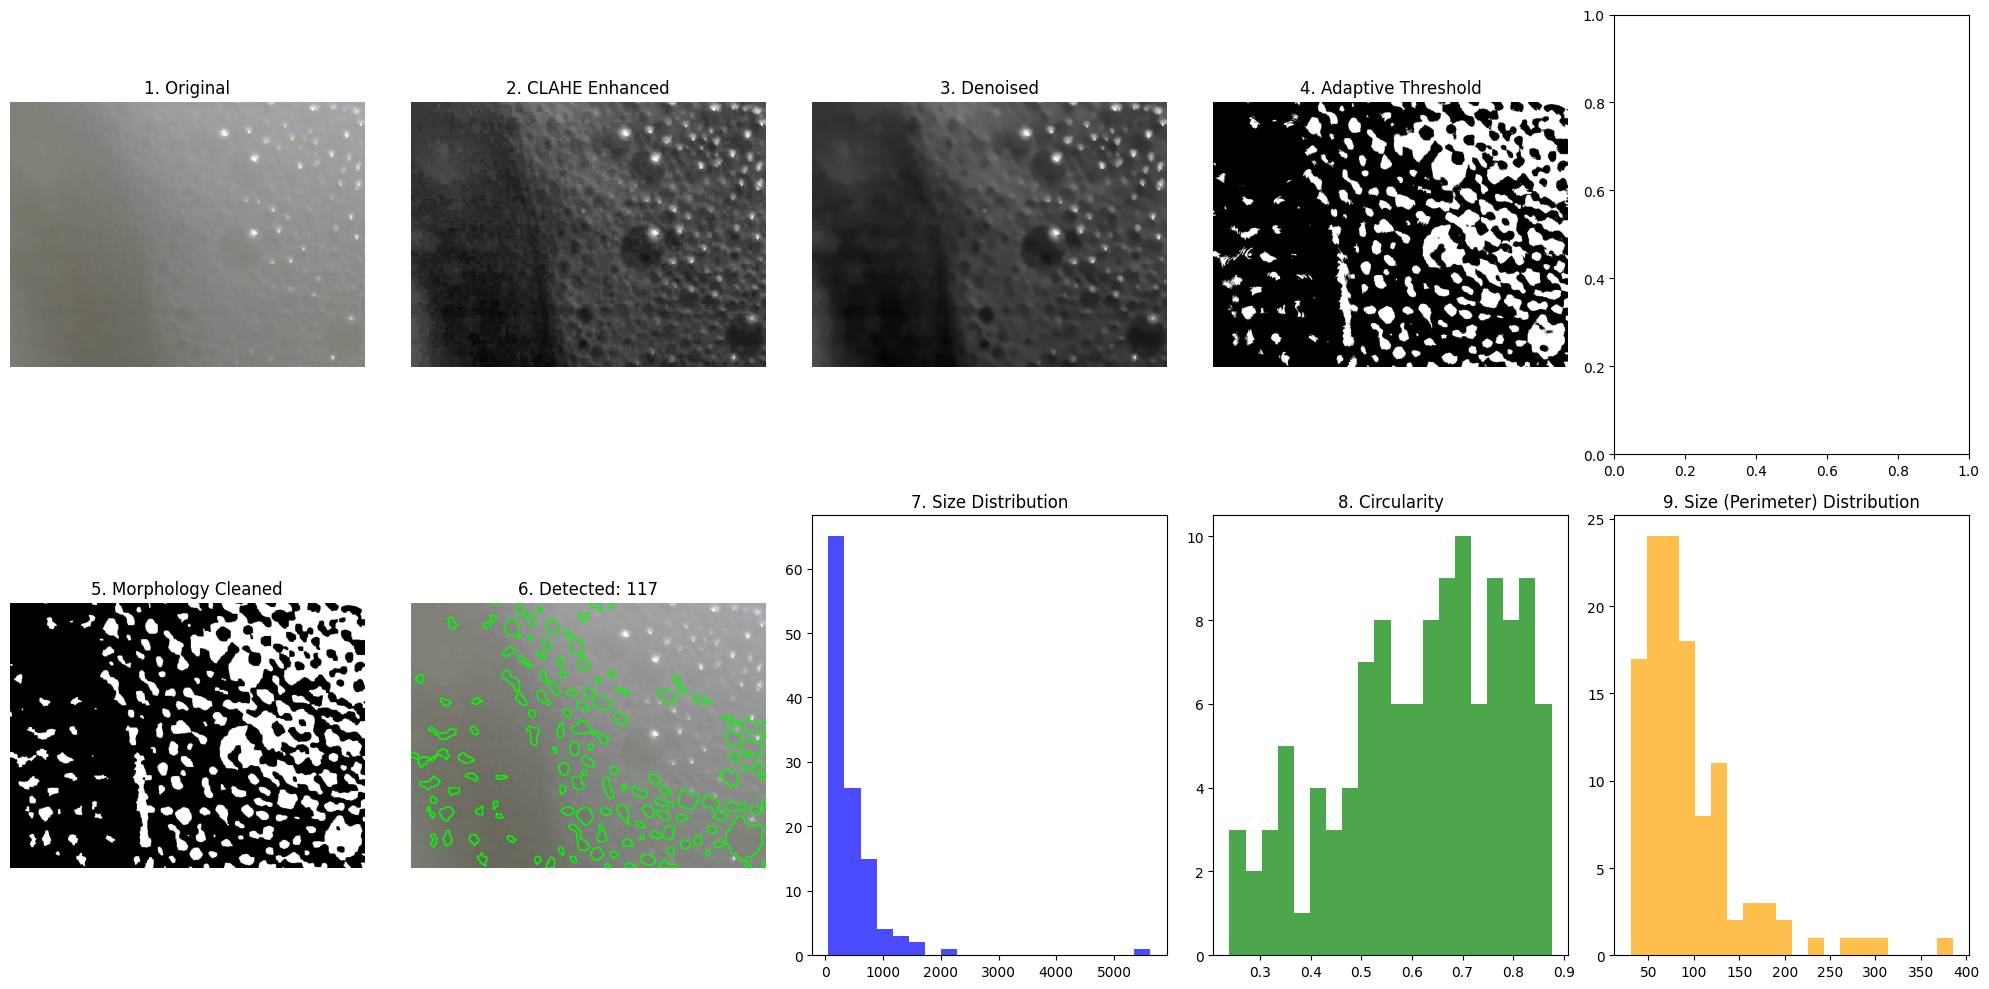

{'area_coverage': np.float64(0.11685823754789272),
 'avg_area': np.float64(459.06410256410254),
 'avg_circularity': np.float64(0.6222296925233359),
 'avg_perimeter': np.float64(93.06838453936781),
 'num_bubbles': 117,
 'std_area': np.float64(600.099263649558)}


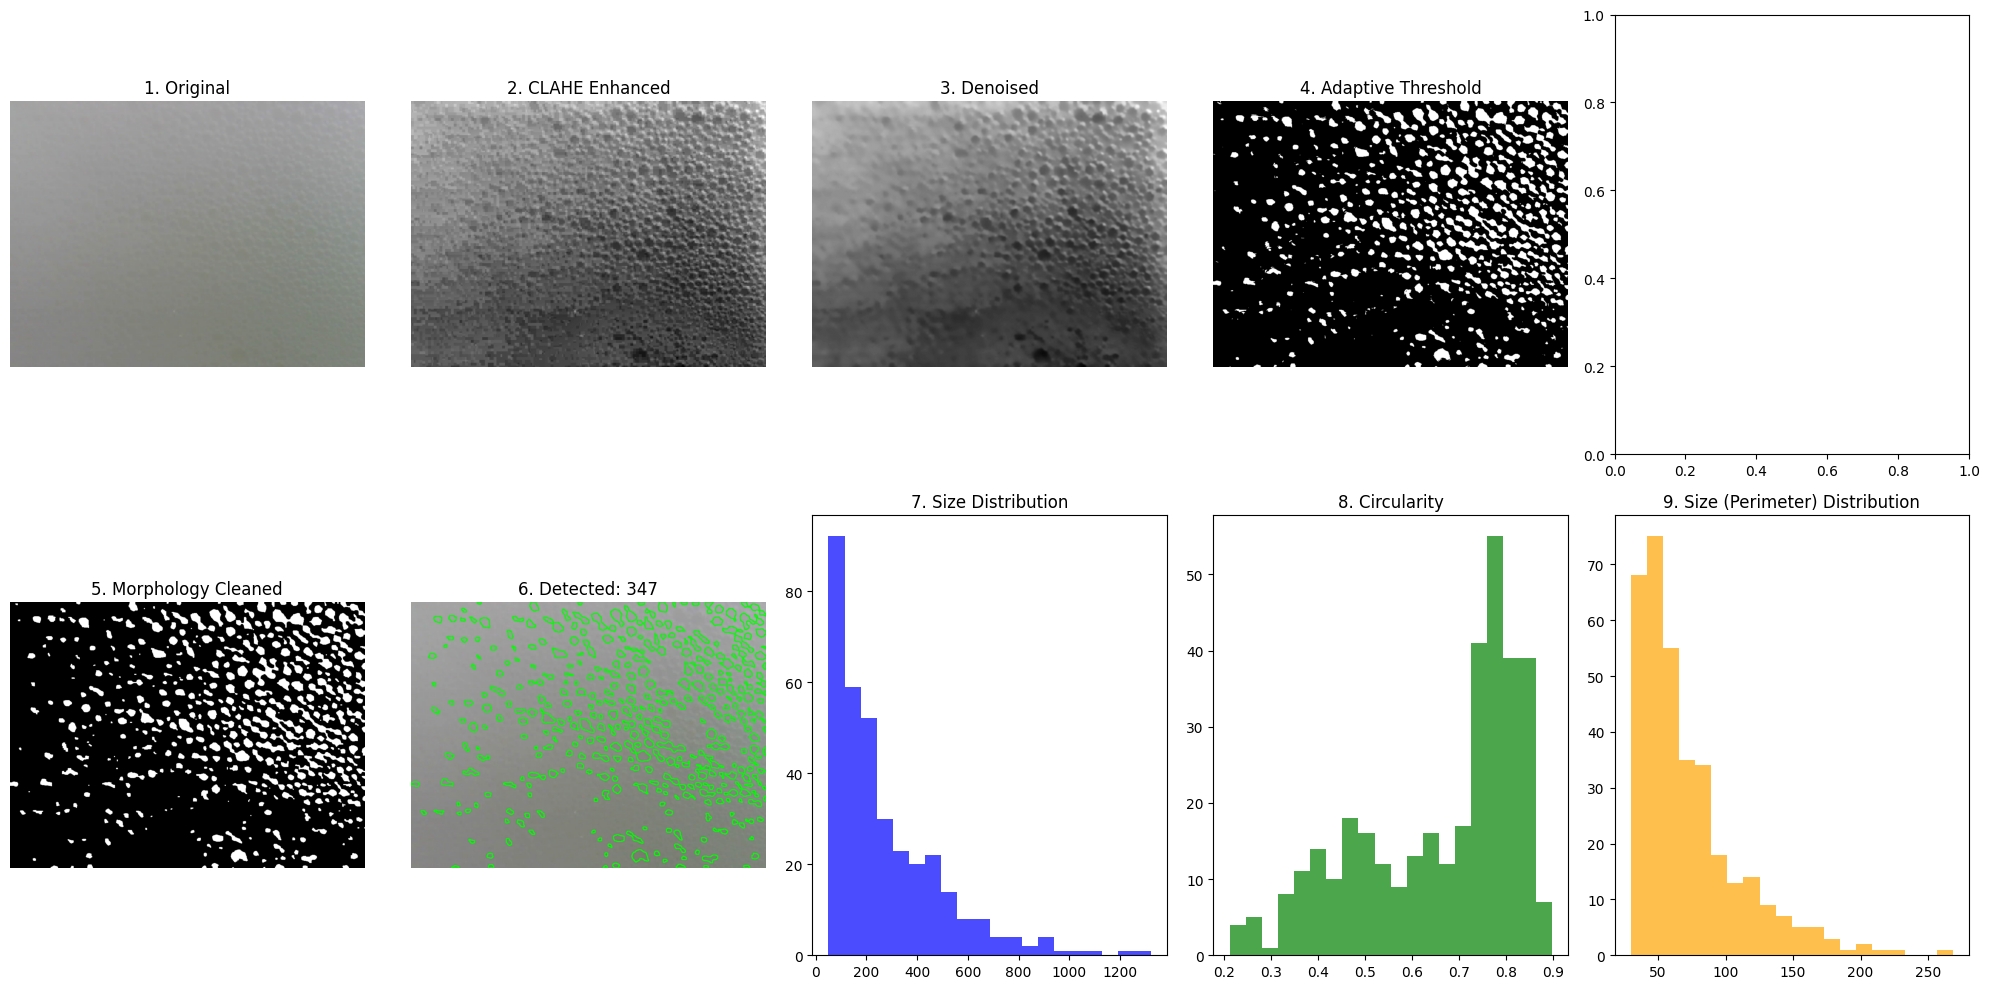

{'area_coverage': np.float64(0.12745924940597192),
 'avg_area': np.float64(273.92939481268013),
 'avg_circularity': np.float64(0.6621287703647327),
 'avg_perimeter': np.float64(71.86582997656006),
 'num_bubbles': 347,
 'std_area': np.float64(217.7787658065707)}


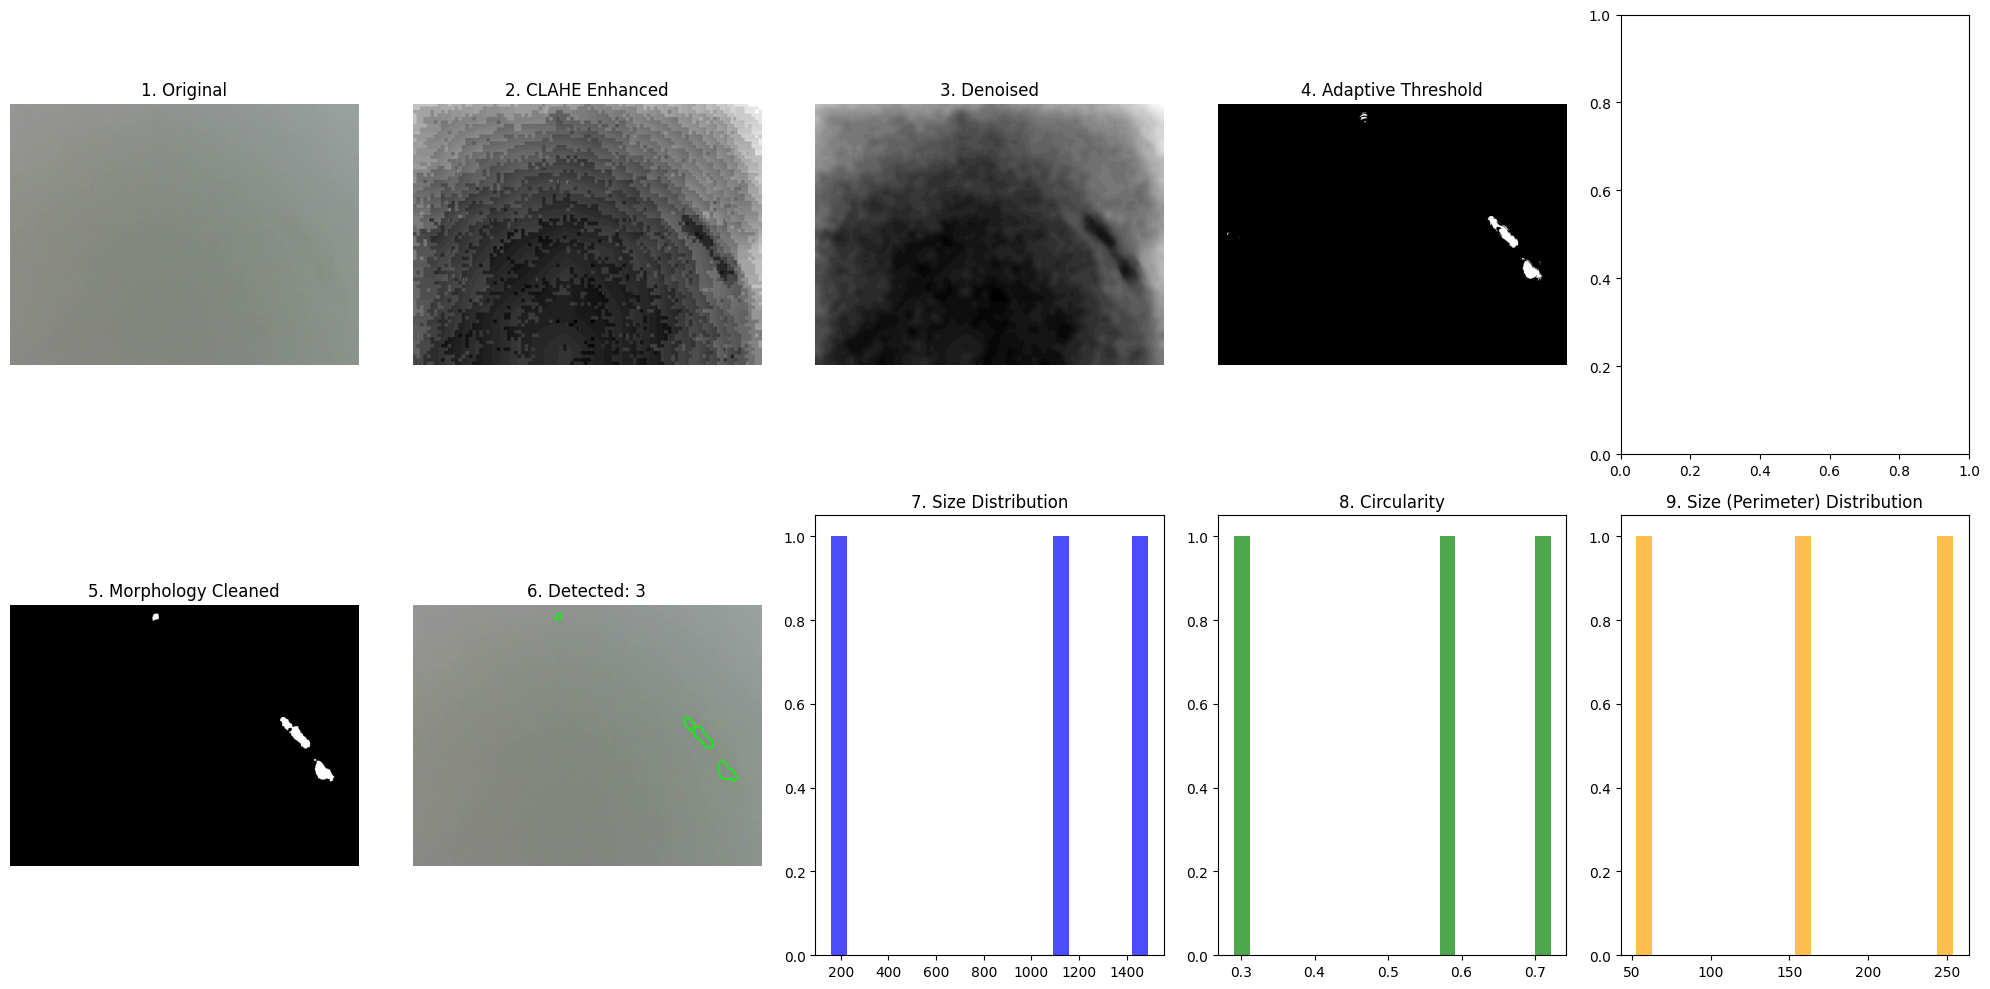

{'area_coverage': np.float64(0.005742708333333333),
 'avg_area': np.float64(918.8333333333334),
 'avg_circularity': np.float64(0.5271721018615882),
 'avg_perimeter': np.float64(154.3062756061554),
 'num_bubbles': 3,
 'std_area': np.float64(559.0054163919663)}


In [15]:
def detect_bubbles_watershed(image_path: str, visualize: bool = True) -> tuple:
    """
    Bubble detection feature extraction using image processing techniques mentioned above.
    
    Args:
        image_path (str): Path to the input image.
        visualize (bool): Whether to visualize the processing steps.
    
    Returns:
        features (dict): Extracted features including number of bubbles, average area, std area,
                         area coverage, average circularity, and average perimeter.
        valid_bubbles (list): List of contours representing detected bubbles.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    # 1. convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape
    
    # 2. CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    # 3. non-local means denoising
    denoised = cv2.fastNlMeansDenoising(enhanced, h=10)
    
    # 4. adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        denoised,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        101,  # Small block size
        3    # C value
    )
    
    # 5. morphological cleaning
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # 6. contour detection
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 6. contour filtering
    min_area = 50
    max_area = (height * width) * 0.5
    
    valid_bubbles = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_area < area < max_area:
            perimeter = cv2.arcLength(cnt, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter ** 2)
                if circularity > 0.2:
                    valid_bubbles.append(cnt)

    # drawing results for visualization
    output = img.copy()
    cv2.drawContours(output, valid_bubbles, -1, (0, 255, 0), 2)
    
    # calculating areas, perimeters and circularities
    bubble_areas = [cv2.contourArea(cnt) for cnt in valid_bubbles]
    bubble_perimeters = [cv2.arcLength(cnt, True) for cnt in valid_bubbles]
    bubble_circularity = [4 * np.pi * cv2.contourArea(cnt) / (cv2.arcLength(cnt, True) ** 2) 
                          for cnt in valid_bubbles if cv2.arcLength(cnt, True) > 0]
    
    # visualising the individual steps
    if visualize:
        fig, axes = plt.subplots(2, 5, figsize=(20, 10))
        
        axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('1. Original')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(enhanced, cmap='gray')
        axes[0, 1].set_title('2. CLAHE Enhanced')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(denoised, cmap='gray')
        axes[0, 2].set_title('3. Denoised')
        axes[0, 2].axis('off')
        
        axes[0, 3].imshow(thresh, cmap='gray')
        axes[0, 3].set_title('4. Adaptive Threshold')
        axes[0, 3].axis('off')
        
        axes[1, 0].imshow(cleaned, cmap='gray')
        axes[1, 0].set_title('5. Morphology Cleaned')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        axes[1, 1].set_title(f'6. Detected: {len(valid_bubbles)}')
        axes[1, 1].axis('off')
        
        axes[1, 2].hist(bubble_areas, bins=20, color='blue', alpha=0.7)
        axes[1, 2].set_title('7. Size Distribution')
        
        axes[1, 3].hist(bubble_circularity, bins=20, color='green', alpha=0.7)
        axes[1, 3].set_title('8. Circularity')
            
        axes[1, 4].hist(bubble_perimeters, bins=20, color='orange', alpha=0.7)
        axes[1, 4].set_title('9. Size (Perimeter) Distribution')
        
        plt.tight_layout()
        plt.show()
    
    # extracting the features from the variables found earlier
    features = {}
    features['num_bubbles'] = len(valid_bubbles)
    features['avg_area'] = np.mean(bubble_areas)
    features['std_area'] = np.std(bubble_areas)
    total_area = np.sum(bubble_areas)
    features['area_coverage'] = total_area / (height * width)
    features['avg_circularity'] = np.mean(bubble_circularity) if bubble_circularity else 0
    features['avg_perimeter'] = np.mean(bubble_perimeters) if bubble_perimeters else 0
    
    return features, valid_bubbles

# poor froth example
features, bubbles = detect_bubbles_watershed('dataset/poorly_froth/20251105160700.jpg', visualize=True)
pprint(features)
    
# good froth example
features, bubbles = detect_bubbles_watershed('dataset/good_froth/20251110140904 (1) (1).jpg', visualize=True)
pprint(features)

# not froth example
features, bubbles = detect_bubbles_watershed('dataset/not_froth/20251107141028.jpg', visualize=True)
pprint(features)

In [16]:
def extract_features_from_dataset(data_folder: str = 'dataset', 
                                   categories: list = ['good_froth', 'poorly_froth', 'not_froth']) -> dict:
    """
    Helper function: Extract features from all images in the dataset.
    
    Args:
        data_folder (str): Path to the dataset folder containing category subfolders.
        categories (list): List of category names to process.
    
    Returns:
        dict: Dictionary with category names as keys and lists of feature dicts as values.
              Format: {'good_froth': [features1, features2, ...], 'poorly_froth': [...], ...}
    """
    all_results = {cat: [] for cat in categories}
    
    # loop through each category folder
    for category in categories:
        folder_path = os.path.join(data_folder, category)
        
        if not os.path.exists(folder_path):
            print(f"Warning: Folder '{folder_path}' does not exist!")
            continue
        
        image_files = [f for f in os.listdir(folder_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        print(f"\nProcessing {category}: {len(image_files)} images")
        
        # loop through each image in the category folder
        for i, img_file in enumerate(image_files, 1):
            img_path = os.path.join(folder_path, img_file)
            
            try:
                # extract features with no visualization
                features, _ = detect_bubbles_watershed(img_path, visualize=False)
                
                features['label'] = category
                features['filename'] = img_file
                
                all_results[category].append(features)
                
                # progress update
                if i % 10 == 0:
                    print(f"  Processed {i}/{len(image_files)} images")
                
            except Exception as e:
                print(f"  ERROR processing {img_file}: {e}")
        
        print(f" Completed {category}: {len(all_results[category])} images processed")
    
    return all_results

In [17]:
def analyze_froth_categories(data_folder: str = 'dataset', 
                             categories: list = ['good_froth', 'poorly_froth', 'not_froth'],
                             selected_features: list = ['area_coverage', 'avg_area', 'avg_circularity', 
                                                        'num_bubbles', 'std_area', 'avg_perimeter']) -> tuple:
    """
    Analyze all images and calculate average features for each category.
    
    Args:
        data_folder (str): Path to the dataset folder containing category subfolders.
        categories (list): List of category names to analyze.
        selected_features (list): Features to include in the summary.
    
    Returns:
        summary (dict): Average features per category.
        comparison_df (pd.DataFrame): DataFrame comparing average features across categories.
        all_results (dict): All extracted features for each image in each category.
    """
    # extract features from dataset
    all_results = extract_features_from_dataset(data_folder, categories)
    
    # calculate average for each feature per category
    print("AVERAGE FEATURES PER CATEGORY")
    
    summary = {}
    
    for category in categories:
        if not all_results[category]:
            print(f"\n{category}: No results found")
            continue
        
        # converting to pandas dataframe for easy averaging
        df = pd.DataFrame(all_results[category])
        
        avg_features = df[selected_features].mean()
        summary[category] = avg_features.to_dict()
        
        print(f"\n{category.upper()}:")
        print(f"  Total images: {len(all_results[category])}")
        for feature in selected_features:
            print(f"  {feature}: {avg_features[feature]:.4f}")
    
    # creating comparison dataframe
    comparison_df = pd.DataFrame(summary).T
    
    print("COMPARISON TABLE\n")
    print(comparison_df.to_string())
    
    return summary, comparison_df, all_results

In [18]:
def extract_features_with_labels(data_folder: str = 'dataset', 
                                 categories: list = ['good_froth', 'poorly_froth', 'not_froth'],
                                 features: list = ['area_coverage', 'avg_area', 'avg_circularity', 
                                                  'num_bubbles', 'std_area', 'avg_perimeter']) -> pd.DataFrame:
    """
    Extract features from all images and create a labeled DataFrame.
    
    Args:
        data_folder (str): Path to the dataset folder containing category subfolders.
        categories (list): List of category names to process.
    
    Returns:
        pd.DataFrame: DataFrame with extracted features and labels for all images.
    """
    # extract features from dataset
    all_results = extract_features_from_dataset(data_folder, categories)
    
    # flatten results into a single list
    all_data = []
    for category in categories:
        all_data.extend(all_results[category])
    
    # create dataframe
    df = pd.DataFrame(all_data)
    
    return df

In [19]:
# Analyze averages for the different categories
categories = ['good_froth', 'poorly_froth', 'not_froth']
features_to_analyze = ['area_coverage', 'avg_area', 'avg_circularity', 
                     'num_bubbles', 'std_area', 'avg_perimeter']
comparison_filepath = 'froth_analysis_summary.csv'
summary, comparison_df, all_results = analyze_froth_categories(selected_features=features_to_analyze, 
                                                               categories=categories)

comparison_df.to_csv(comparison_filepath)
print(f"\nResults saved to '{comparison_filepath}'")


# Extracting features for ML
df = extract_features_with_labels()

print(df.head())

features_filepath = 'froth_features_labeled.csv'
df.to_csv(features_filepath, index=False)
print(f"\nFeatures saved to '{features_filepath}'")


Processing good_froth: 38 images
  Processed 10/38 images
  Processed 20/38 images
  Processed 30/38 images
 Completed good_froth: 38 images processed

Processing poorly_froth: 76 images
  Processed 10/76 images
  Processed 20/76 images
  Processed 30/76 images
  Processed 40/76 images
  Processed 50/76 images
  Processed 60/76 images
  Processed 70/76 images
 Completed poorly_froth: 76 images processed

Processing not_froth: 11 images


/Users/jonas/Documents/GitHub/sutd/capstone/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jonas/Documents/GitHub/sutd/capstone/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jonas/Documents/GitHub/sutd/capstone/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jonas/Documents/GitHub/sutd/capstone/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jonas/Documents/GitHub/sutd/capstone/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divi

  Processed 10/11 images
 Completed not_froth: 11 images processed
AVERAGE FEATURES PER CATEGORY

GOOD_FROTH:
  Total images: 38
  area_coverage: 0.1870
  avg_area: 381.6422
  avg_circularity: 0.6654
  num_bubbles: 333.3947
  std_area: 337.5459
  avg_perimeter: 83.3574

POORLY_FROTH:
  Total images: 76
  area_coverage: 0.0887
  avg_area: 625.3305
  avg_circularity: 0.5763
  num_bubbles: 69.3684
  std_area: 889.3514
  avg_perimeter: 110.7944

NOT_FROTH:
  Total images: 11
  area_coverage: 0.0021
  avg_area: 437.8750
  avg_circularity: 0.4812
  num_bubbles: 4.2727
  std_area: 251.9969
  avg_perimeter: 90.0082
COMPARISON TABLE

              area_coverage    avg_area  avg_circularity  num_bubbles    std_area  avg_perimeter
good_froth         0.187012  381.642224         0.665423   333.394737  337.545915      83.357369
poorly_froth       0.088690  625.330516         0.576273    69.368421  889.351396     110.794408
not_froth          0.002055  437.875000         0.481204     4.272727  251.9

/Users/jonas/Documents/GitHub/sutd/capstone/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jonas/Documents/GitHub/sutd/capstone/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jonas/Documents/GitHub/sutd/capstone/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jonas/Documents/GitHub/sutd/capstone/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jonas/Documents/GitHub/sutd/capstone/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divi

  Processed 10/11 images
 Completed not_froth: 11 images processed
   num_bubbles    avg_area    std_area  area_coverage  avg_circularity  \
0          479  290.059499  240.570660       0.186306         0.677646   
1          181  606.464088  539.362710       0.238827         0.587493   
2          130  536.923077  539.763169       0.151864         0.679807   
3          354  267.358757  233.125305       0.126911         0.677780   
4          480  287.087500  228.754330       0.184782         0.661801   

   avg_perimeter       label                filename  
0      73.160117  good_froth  20251110140945 (1).jpg  
1     112.517508  good_froth      20251105164316.jpg  
2      95.134675  good_froth      20251105164510.jpg  
3      69.867867  good_froth  20251110140904 (2).jpg  
4      74.892702  good_froth  20251110141027 (1).jpg  

Features saved to 'froth_features_labeled.csv'


Training set size: 100
Test set size: 25

Test Accuracy: 0.9600 (96.00%)
Classification Report:
              precision    recall  f1-score   support

  good_froth       0.89      1.00      0.94         8
   not_froth       1.00      1.00      1.00         2
poorly_froth       1.00      0.93      0.97        15

    accuracy                           0.96        25
   macro avg       0.96      0.98      0.97        25
weighted avg       0.96      0.96      0.96        25



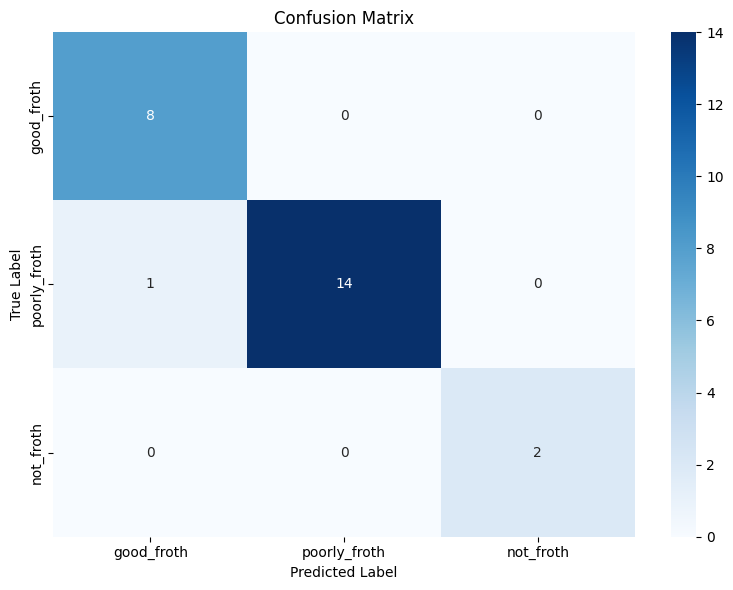


Feature Importance:
           feature  importance
3      num_bubbles    0.381459
0    area_coverage    0.248654
4         std_area    0.134886
2  avg_circularity    0.128336
1         avg_area    0.059903
5    avg_perimeter    0.046763


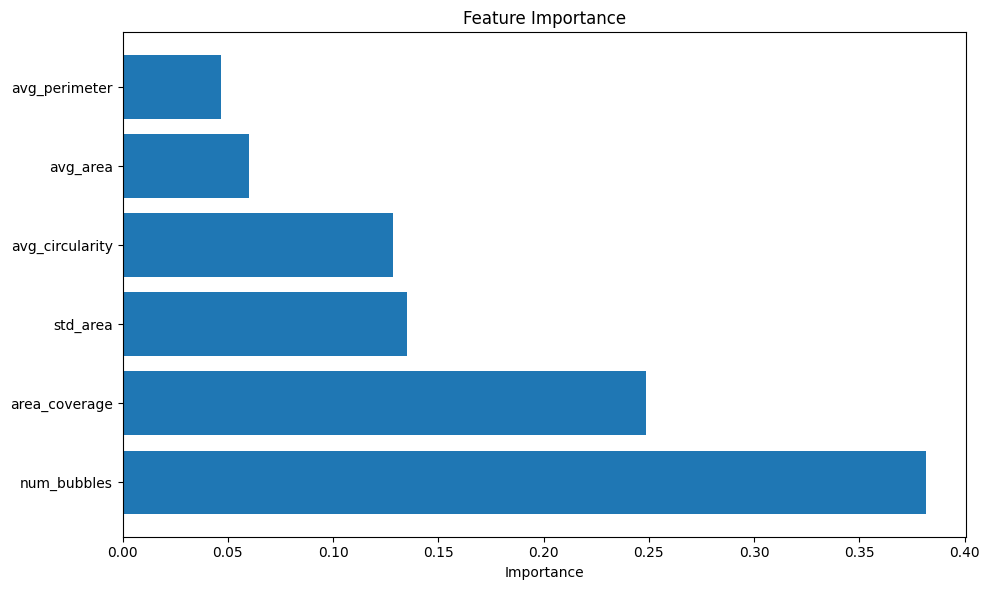


Model saved to 'models/froth_classifier.pkl'


In [20]:
def train_classifier(df, 
                     test_size=0.2, 
                     random_state=42, 
                     feature_cols: list = ['area_coverage', 'avg_area', 'avg_circularity', 
                                           'num_bubbles', 'std_area', 'avg_perimeter']) -> tuple:
    """
    Train a supervised RandomForest classifier with train/test split.
    
    Args:
        df (pd.DataFrame): DataFrame containing features and labels.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Random seed for reproducibility.
        feature_cols (list): List of feature column names to use for training.
        
    Returns:
        clf: Trained classifier.
        scaler: Fitted StandardScaler.
        accuracy (float): Accuracy on the test set.
    """
    
    for feature in feature_cols:
        if feature not in df.columns:
            raise ValueError(f"Feature '{feature}' not found in DataFrame columns.")
    
    X = df[feature_cols].values
    y = df['label'].values
    
    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}\n")
    
    # standardizing features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # training randomforest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    clf.fit(X_train_scaled, y_train)
    
    # predict on test set
    y_pred = clf.predict(X_test_scaled)
    
    # calculating accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # calculating classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # calculating confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=['good_froth', 'poorly_froth', 'not_froth'])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['good_froth', 'poorly_froth', 'not_froth'],
                yticklabels=['good_froth', 'poorly_froth', 'not_froth'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # calculating feature importance as a reference for future experiments
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': clf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return clf, scaler, accuracy

data_filepath = 'froth_features_labeled.csv'
df = pd.read_csv(data_filepath)

included_features = FEATURES_TO_USE_FOR_TRAINING
classifier, scaler, accuracy = train_classifier(df, test_size=0.2, feature_cols=included_features)

# saving model
model_filepath = 'models/froth_classifier.pkl'
with open(model_filepath, 'wb') as f:
    pickle.dump({'model': classifier, 'scaler': scaler}, f)
print(f"\nModel saved to '{model_filepath}'")

In [ ]:
def train_classifier_randomized_search(df, 
                                       random_state=42,
                                       test_size=0.2,
                                       n_iter=100,
                                       feature_cols: list = ['area_coverage', 'avg_area', 'avg_circularity', 
                                                           'num_bubbles', 'std_area', 'avg_perimeter']) -> tuple:
    """
    Train with RandomizedSearchCV for more efficient hyperparameter tuning.
    
    Args:
        df (pd.DataFrame): DataFrame containing features and labels.
        random_state (int): Random seed for reproducibility.
        test_size (float): Proportion for test set.
        n_iter (int): Number of parameter settings sampled.
        feature_cols (list): List of feature column names to use.
    
    Returns:
        final_model: Trained RandomForestClassifier with best hyperparameters.
        scaler: Fitted StandardScaler.
        best_params (dict): Best hyperparameters found.
    """
    
    for feature in feature_cols:
        if feature not in df.columns:
            raise ValueError(f"Feature '{feature}' not found in DataFrame columns.")
    
    X = df[feature_cols].values
    y = df['label'].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # parameter distributions
    param_distributions = {
        'n_estimators': randint(50, 500),           # Random integers from 50-500
        'max_depth': [None] + list(range(5, 50)),   # None or 5-50
        'min_samples_split': randint(2, 20),        # Random from 2-20
        'min_samples_leaf': randint(1, 10),         # Random from 1-10
        'max_features': uniform(0.1, 0.9),          # Random float from 0.1-1.0
        'bootstrap': [True, False]                  # Boolean
    }
    
    # creating RandomizedSearchCV instance
    random_search = RandomizedSearchCV(
        RandomForestClassifier(random_state=random_state),
        param_distributions=param_distributions,
        n_iter=n_iter,           
        cv=5,                     # x-fold cross-validation
        scoring='accuracy',
        verbose=2,
        n_jobs=-1,
        random_state=random_state,
        return_train_score=True
    )
    
    print(f"Testing {n_iter} random parameter combinations...")
    random_search.fit(X_train_scaled, y_train)
    print("\n")
    
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV score: {random_search.best_score_:.4f}")
    
    # final evaluation with best estimator
    final_model = random_search.best_estimator_
    y_pred = final_model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nTest accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    # classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=random_search.classes_,
                yticklabels=random_search.classes_)
    plt.title('Confusion Matrix (Test Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return final_model, scaler, random_search.best_params_

Testing 100 random parameter combinations...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=32, max_features=0.2650913108795474, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.1s
[CV] END bootstrap=True, max_depth=32, max_features=0.2650913108795474, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.1s
[CV] END bootstrap=True, max_depth=32, max_features=0.2650913108795474, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.1s
[CV] END bootstrap=True, max_depth=32, max_features=0.2650913108795474, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.1s
[CV] END bootstrap=True, max_depth=32, max_features=0.2650913108795474, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=0.1185260448662222, min_samples_leaf=2, min_samples_split=13, n_estimators=463; total time

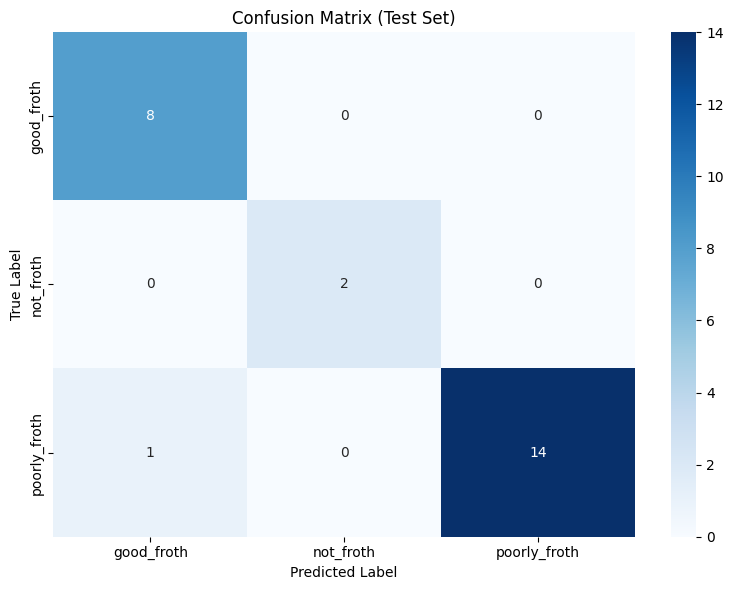

In [22]:
model, scaler, params = train_classifier_randomized_search(df, 
                                    random_state=42,
                                    test_size=0.2,
                                    n_iter=100,
                                    feature_cols=FEATURES_TO_USE_FOR_TRAINING)

In [23]:
def classify_froth_image(image_path, 
                         model_path='models/froth_classifier.pkl', 
                         features_cols: list = ['area_coverage', 'avg_area', 'avg_circularity', 
                                                'num_bubbles', 'std_area', 'avg_perimeter']) -> dict:
    """
    Classify a froth image using the trained model.
    
    Args:
        image_path: Path to the image file
        model_path: Path to the saved model pickle file
        
    Returns:
        dict: Classification results containing:
            - prediction: The predicted class label
            - probabilities: Dictionary of probabilities for each class
            - confidence: Confidence score (max probability)
            - features: Extracted features from the image
    """
    # loading the model and scaler
    with open(model_path, 'rb') as f:
        saved_data = pickle.load(f)
        model = saved_data['model']
        scaler = saved_data['scaler']
    
    # extracing features from the image
    try:
        features, _ = detect_bubbles_watershed(image_path, visualize=False)
    except Exception as e:
        return {
            'error': f"Failed to process image: {str(e)}",
            'prediction': None,
            'probabilities': None,
            'confidence': None,
            'features': None
        }
    
    # checking if all required features are present
    for col in features_cols:
        if col not in features:
            raise ValueError(f"Feature '{col}' not found in extracted features.")

    X = np.array([[features[col] for col in features_cols]])
    
    X_scaled = scaler.transform(X)
    
    # making prediction
    prediction = model.predict(X_scaled)[0]
    
    # getting prediction probabilities
    probabilities = model.predict_proba(X_scaled)[0]
    
    # getting class names
    class_names = model.classes_
    
    # creating probability dictionary
    prob_dict = {class_name: prob for class_name, prob in zip(class_names, probabilities)}
    
    # getting confidence of the prediction
    confidence = np.max(probabilities)
    
    return {
        'prediction': prediction,
        'probabilities': prob_dict,
        'confidence': confidence,
        'features': features
    }


# example on how to classify an image with the trained model
result = classify_froth_image('data/photo_2025-11-12_14-58-08.jpg', features_cols=FEATURES_TO_USE_FOR_TRAINING)
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"\nProbabilities:")
for class_name, prob in result['probabilities'].items():
    print(f"  {class_name}: {prob:.2%}")
    
print("\nExtracted Features:")
for feature in result['features']:
    print(f"  {feature}: {result['features'][feature]:.4f}")


Prediction: poorly_froth
Confidence: 79.00%

Probabilities:
  good_froth: 2.00%
  not_froth: 19.00%
  poorly_froth: 79.00%

Extracted Features:
  num_bubbles: 116.0000
  avg_area: 211.4741
  std_area: 238.3804
  area_coverage: 0.0266
  avg_circularity: 0.4539
  avg_perimeter: 75.4363
